### ML Regression 
#### Date: 2026-01-30

**Topics**:
> 1. Lasso
> 2. Ridge
> 3. SVM
> 4. GradientBoostingRegressor

**Materials**:
> 1. [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
> 2. [Ridge & Lasso](https://www.geeksforgeeks.org/machine-learning/ridge-regression-vs-lasso-regression/)

**Лінійна Регресія**
Лінійна регресія передбачає, що між незалежними змінними X, X та залежною змінною Y існує лінійна залежність. Модель намагається знайти пряму, яка найкраще відповідає цим точкам


**Особливості**:  
**Інтерпретація**: Кожен коефіцієнт вказує на силу впливу кожної ознаки на залежну змінну  


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

df = sns.load_dataset("diamonds")

X = df.drop(columns=["price"])
y = df["price"]



In [3]:
X = df.drop(columns=["price"])
y = df["price"]


In [4]:
num_cols = X.select_dtypes(include=["float64","int64"]).columns
cat_cols = X.select_dtypes(include=["object","category"]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


#### Ridge 
Рідж регресія використовує регуляризацію L2, яка додає штраф на квадрат значень коефіцієнтів. Це допомагає зменшити величину коефіцієнтів, але не призводить до нульових значень 

Обмеження на ваги має круглу форму

> зменшує ваги \
> бореться з мультиколінеарністю \
> стабілізує модель

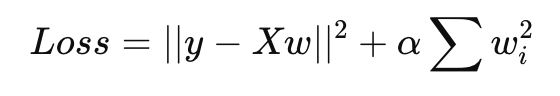

| Параметр | Значення           |
| -------- | ------------------ |
| alpha    | сила регуляризації |


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

ridge = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

print("Ridge MAE:", mean_absolute_error(y_test, pred_ridge))
print("Ridge R2:", r2_score(y_test, pred_ridge))


#### Lasso
Лассо регресія використовує регуляризацію L1, яка додає штраф на абсолютні значення коефіцієнтів. Це призводить до нульових коефіцієнтів для менш важливих ознак, допомагаючи вибирати важливі ознаки

відбирає тільки важливі ознаки

| Параметр | Значення                                |
| -------- | --------------------------------------- |
| alpha    | більший -> більше занулених коефіцієнтів |


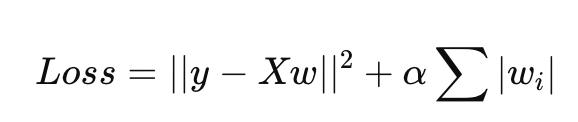

**Особливості**:  
**Вибір ознак**: Лассо автоматично відкидає неважливі ознаки  
**Чутливість**: Сильна регуляризація може призвести до надмірно простої моделі  

In [ ]:
from sklearn.linear_model import Lasso

lasso = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.05, max_iter=10000))
])

lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)

print("LASSO MAE:", mean_absolute_error(y_test, pred_lasso))


In [ ]:
features = lasso.named_steps["preprocess"].get_feature_names_out()
coefs = lasso.named_steps["model"].coef_

pd.DataFrame({"feature":features, "coef":coefs}).query("coef != 0").head()


#### Support Vector Regression (SVR)
SVM будує ε-трубку, в межах якої помилки не штрафуються.


| Параметр | Що робить               |
| -------- | ----------------------- |
| C        | штраф за помилки        |
| epsilon  | ширина трубки           |
| gamma    | складність нелінійності |


In [ ]:
from sklearn.svm import SVR

svr = Pipeline([
    ("preprocess", preprocess),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1))
])

svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

print("SVR MAE:", mean_absolute_error(y_test, pred_svr))


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et = Pipeline([
    ("preprocess", preprocess),
    ("model", ExtraTreesRegressor(n_estimators=400, random_state=42))
])

et.fit(X_train, y_train)
pred_et = et.predict(X_test)

print("ExtraTrees MAE:", mean_absolute_error(y_test, pred_et))


| Метрика                              | Формула                             | Діапазон значень | Пояснення                                                                   | Приклад використання                                                                                        |
|--------------------------------------|-------------------------------------|-------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Середня абсолютна помилка (MAE)      | 1/n * Σ|y - ŷ|   | [0, +∞)           | Середнє абсолютне відхилення передбачених значень від істинних. Ця метрика робить однакові величини помилок пропорційними. | Прогнозування ціни: Середнє абсолютне відхилення 500 одиниць від реальної ціни. |
| Середня квадратична помилка (MSE)    | 1/n * Σ(y - ŷ)^2                   | [0, +∞)           | Середнє квадратичне відхилення передбачених значень від істинних. Ця метрика штрафує за великі відхилення більше, ніж за малі.  | Прогнозування ціни: Середнє квадратичне відхилення 50 000 одиниць від реальної ціни. |
| Корінь середньоквадратичної помилки (RMSE) | √MSE                            | [0, +∞)           | Квадратний корінь з середньоквадратичної помилки. Ця метрика вимірює середнє значення помилки в тих самих одиницях, що і цільова змінна. | Прогнозування ціни: Корінь середньоквадратичної помилки 223.61 одиниці від реальної ціни. |
| Коефіцієнт детермінації (R^2)        | 1 - (Σ(y - ŷ)^2 / Σ(y - ȳ)^2)      | [0, 1]            | Коефіцієнт, який вимірює частку дисперсії залежної змінної, пояснену моделлю. Він вказує на те, яка частка варіації даних пояснюється моделлю. | Прогнозування ціни: R^2 дорівнює 0.75, що означає, що 75% варіації ціни пояснюється моделлю. |


**Градієнтний Бустинг (Gradient Boosting)**  
Градієнтний бустинг - це метод ансамблевого навчання, який використовує слабкі моделі, такі як дерева рішень, і об’єднує їх для підвищення продуктивності. Він працює, додаючи нові моделі, які коригують помилки попередніх моделей, використовуючи градієнт спаду. Алгоритм намагається мінімізувати функцію втрат, покращуючи точність.

Кожне нове дерево вчиться на помилках попередніх.

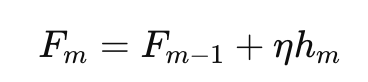


| Параметр      | Значення           |
| ------------- | ------------------ |
| learning_rate | крок оновлення     |
| n_estimators  | кількість ітерацій |
| max_depth     | складність         |


**Особливості:**

> **Темп навчання**: Градієнтний бустинг чутливий до темпу навчання η  
> **Низькі значення η** роблять навчання більш повільним, але менш схильним до перенавчання  
> **Регуляризація**: Алгоритм включає параметри регуляризації для зменшення перенавчання  
> **Інтерпретованість**: Модель менш інтерпретована, оскільки вона об’єднує безліч слабких моделей  
> **Гнучкість**: Градієнтний бустинг може бути налаштований для вирішення різноманітних завдань, включаючи класифікацію, регресію та ранжування  

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline([
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        learning_rate=0.05,
        n_estimators=600,
        max_depth=5
    ))
])

gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)

print("GBR MAE:", mean_absolute_error(y_test, pred_gbr))
